In [9]:
import config as config
from pathlib import Path
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
model = 'ElasticNet_ChatGPT'
data_dir = config.TRAINED_DIR
data_dir

WindowsPath('c:/DeepRESTORE/llm_brain_representations/Trained')

In [ ]:
def plot_r2(model):
    destination_dir = Path(config.CUR_DIR, 'Results', 'Images')
    root_dir = config.TRAINED_DIR
    subject_r2_scores = {}

    for subject in sorted(os.listdir(root_dir)):
        subject_path = os.path.join(root_dir, subject, "Mapping", model)
        if os.path.exists(subject_path):
            r2_scores = []
            
            for fold_file in sorted(os.listdir(subject_path)):
                if fold_file.endswith(".npy"):
                    fold_path = os.path.join(subject_path, fold_file)
                    values = np.load(fold_path) 
                    r2_scores.append(values[2])  
            
            if r2_scores:
                subject_r2_scores[subject] = r2_scores

    subjects = []
    scores = []
    
    for subject, r2_values in subject_r2_scores.items():
        subjects.extend([subject] * len(r2_values))
        scores.extend(r2_values)

    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))
    
    # Boxplot with mean as square
    sns.boxplot(x=subjects, y=scores, showmeans=True, meanprops={"marker": "s", "markerfacecolor": "red"}, 
                palette="coolwarm")
    
    # Overlay individual points
    sns.stripplot(x=subjects, y=scores, color="black", size=6, jitter=True, alpha=0.7)

    plt.xlabel("Subjects", fontsize=12, fontweight="bold")
    plt.ylabel("R²", fontsize=12, fontweight="bold")

    # Increase font size of ticks
    plt.xticks(rotation=45, fontsize=14, fontweight="bold", color="black")
    plt.yticks(fontsize=14, fontweight="bold", color="black")

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    os.makedirs(destination_dir, exist_ok=True)

    filename = Path(destination_dir, f'{model}.png')
    plt.savefig(filename, dpi=800)


C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_19612\99024206.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=subjects, y=scores, showmeans=True, meanprops={"marker": "s", "markerfacecolor": "red"},


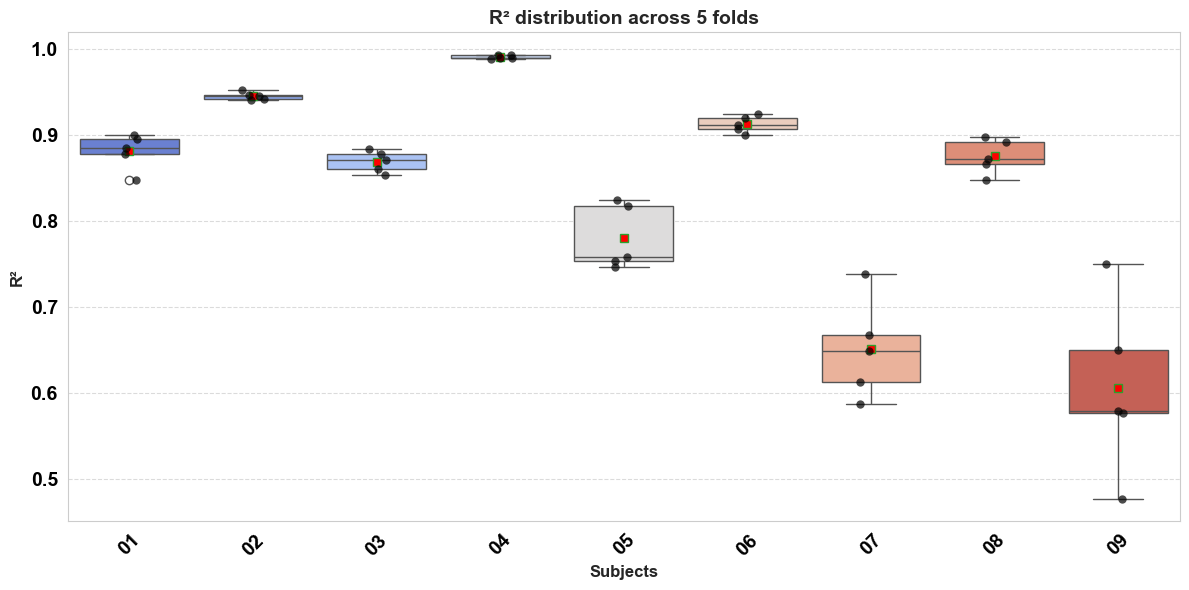

In [42]:
plot_r2(model='ElasticNet_ChatGPT')

C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_19612\99024206.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=subjects, y=scores, showmeans=True, meanprops={"marker": "s", "markerfacecolor": "red"},


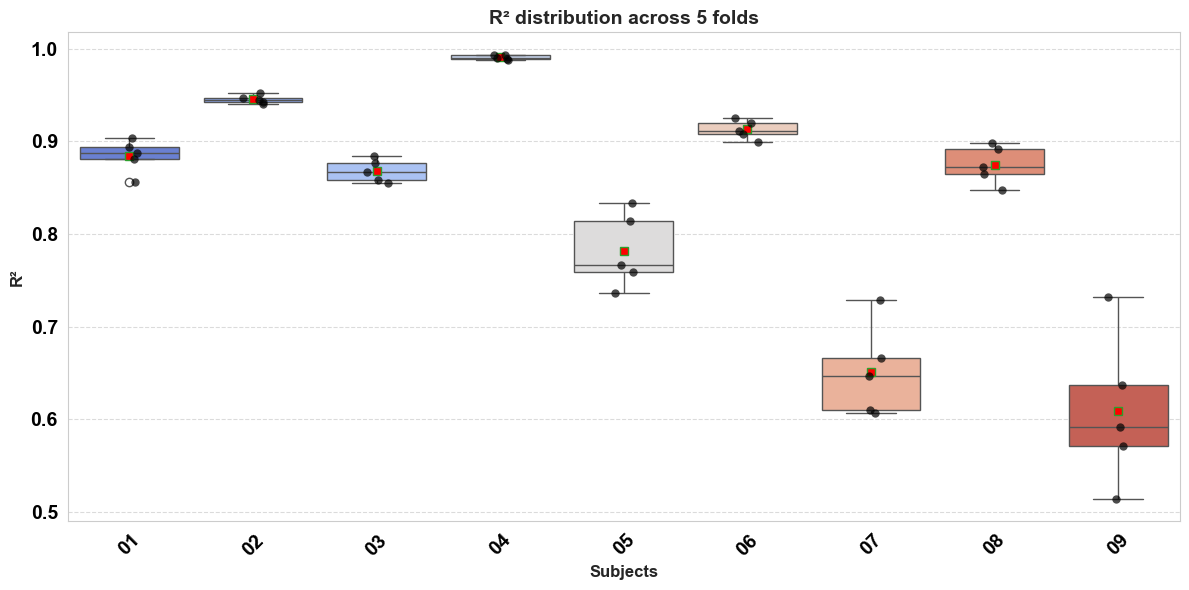

In [43]:
plot_r2(model='ElasticNet_FastText')

In [38]:
def get_r2_scores(model):
    root_dir = config.TRAINED_DIR
    subject_r2_scores = {}

    for subject in sorted(os.listdir(root_dir)):
        subject_path = os.path.join(root_dir, subject, "Mapping", model)
        if os.path.exists(subject_path):
            r2_scores = []
            
            for fold_file in sorted(os.listdir(subject_path)):
                if fold_file.endswith(".npy"):
                    fold_path = os.path.join(subject_path, fold_file)
                    values = np.load(fold_path) 
                    r2_scores.append(values[2])  
            
            if r2_scores:
                subject_r2_scores[subject] = r2_scores
    
    return subject_r2_scores

In [39]:
dic = get_r2_scores(model='ElasticNet_FastText')

In [40]:
dic

{'01': [0.90393757035417,
  0.8806203729746928,
  0.893536058293317,
  0.8563422972091845,
  0.8872641562281025],
 '02': [0.9517727589200585,
  0.9470166062636579,
  0.9444277416401577,
  0.9425417482768322,
  0.9400031598308989],
 '03': [0.858111604114525,
  0.8547600716283918,
  0.8669344767401103,
  0.8766343349957012,
  0.8841602935867925],
 '04': [0.9930125429953466,
  0.9889262832429789,
  0.9882534472736839,
  0.9936135776952204,
  0.989685603104261],
 '05': [0.7666353995848674,
  0.813656594538321,
  0.8334899840984222,
  0.7592988825921817,
  0.7367216970002765],
 '06': [0.9114897032243391,
  0.9201812210708944,
  0.9080690524722062,
  0.9246692809988842,
  0.899581397274598],
 '07': [0.6094924883779107,
  0.6464984508969133,
  0.6065327478377669,
  0.6660051033563721,
  0.7292270212943441],
 '08': [0.8471819539082741,
  0.8982934798265274,
  0.8652105677743285,
  0.8920693191818827,
  0.8720088414193621],
 '09': [0.5709454976514873,
  0.6367058249643611,
  0.5921888861301947,